### altimetry data processing 

In [1]:
import numpy as np
from glob import glob
import xarray as xr
from shapely import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.functions import meter2deg
from utils.functions import sample_from_raster


In [2]:
path_ht_spahet = 'data/dianchi-lake/swot-pixc/raster_height_spahet.nc'
path_lake_vec = 'data/dianchi-lake/hydrolake_dianchi_edit.gpkg'
paths_atl13 = sorted(glob('data/dianchi-lake/icesat2/ATL13/*.h5'))
path_atl13 = paths_atl13[0] 
path_atl13  # check the selected ATL13 file


'data/dianchi-lake/icesat2/ATL13/106700352_ATL13_20230506123651_07051901_006_02_subsetted.h5'

In [3]:
## read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)
# ## read geoid correction file
raster_ht_spahet = xr.open_dataset(path_ht_spahet) 
## read ATL13 data
atl13_xr = xr.open_dataset(path_atl13, group='gt1l', engine='h5netcdf')
atl13_xr
# raster_ht_spahet


<xarray.Dataset> Size: 253kB
Dimensions:                        (delta_time: 628, ds_sseg_quality: 4)
Coordinates:
  * delta_time                     (delta_time) datetime64[ns] 5kB 2023-05-06...
    segment_lat                    (delta_time) float64 5kB ...
    segment_lon                    (delta_time) float64 5kB ...
Dimensions without coordinates: ds_sseg_quality
Data variables: (12/72)
    atl13refid                     (delta_time) float64 5kB ...
    bottom_lat                     (delta_time) float64 5kB ...
    bottom_lon                     (delta_time) float64 5kB ...
    cloud_flag_asr_atl09           (delta_time) float32 3kB ...
    cloud_flag_atm_atl09           (delta_time) float32 3kB ...
    cycle_number                   (delta_time) int8 628B ...
    ...                             ...
    sseg_start_lon                 (delta_time) float64 5kB ...
    stdev_water_surf               (delta_time) float32 3kB ...
    subsurface_attenuation         (delta_time) float32 3kB ...
    subsurface_backscat_ampltd     (delta_time) float32 3kB ...
    transect_id                    (delta_time) float32 3kB ...
    water_depth                    (delta_time) float32 3kB ...
Attributes:
    Description:         Contains per-beam data products.
    atlas_beam_type:     strong
    atlas_pce:           pce1
    atlas_spot_number:   1
    atmosphere_profile:  profile_1
    data_rate:           Data within this group are stored at the inland wate...
    groundtrack_id:      gt1l
    sc_orientation:      Backward

In [4]:
## create a interior buffered lake vector
lake_decrease_gdf = lake_gdf.copy()
lon_center = lake_decrease_gdf.bounds.mean(axis=1).values
utm_zone = np.floor(lon_center/6)+31
epsg_code = f'326{int(utm_zone[0])}'
lake_decrease_gdf = lake_decrease_gdf.to_crs(epsg=epsg_code)
lake_decrease_gdf['geometry'] = lake_decrease_gdf.geometry.buffer(-1000)
lake_decrease_gdf = lake_decrease_gdf.to_crs(epsg=4326)
## select the data within the lake area
points = [Point(lon, lat) for lon, lat in zip(atl13_xr['segment_lon'].values, atl13_xr['segment_lat'].values)]
ids_valid_atl13 = np.where(lake_decrease_gdf.geometry[0].contains(points))[0]
atl13_xr_mask = atl13_xr.isel({'delta_time': ids_valid_atl13})
atl13_xr_mask


<xarray.Dataset> Size: 184kB
Dimensions:                        (delta_time: 456, ds_sseg_quality: 4)
Coordinates:
  * delta_time                     (delta_time) datetime64[ns] 4kB 2023-05-06...
    segment_lat                    (delta_time) float64 4kB 24.91 ... 24.77
    segment_lon                    (delta_time) float64 4kB 102.7 ... 102.7
Dimensions without coordinates: ds_sseg_quality
Data variables: (12/72)
    atl13refid                     (delta_time) float64 4kB ...
    bottom_lat                     (delta_time) float64 4kB ...
    bottom_lon                     (delta_time) float64 4kB ...
    cloud_flag_asr_atl09           (delta_time) float32 2kB ...
    cloud_flag_atm_atl09           (delta_time) float32 2kB ...
    cycle_number                   (delta_time) int8 456B ...
    ...                             ...
    sseg_start_lon                 (delta_time) float64 4kB ...
    stdev_water_surf               (delta_time) float32 2kB ...
    subsurface_attenuation         (delta_time) float32 2kB ...
    subsurface_backscat_ampltd     (delta_time) float32 2kB ...
    transect_id                    (delta_time) float32 2kB ...
    water_depth                    (delta_time) float32 2kB ...
Attributes:
    Description:         Contains per-beam data products.
    atlas_beam_type:     strong
    atlas_pce:           pce1
    atlas_spot_number:   1
    atmosphere_profile:  profile_1
    data_rate:           Data within this group are stored at the inland wate...
    groundtrack_id:      gt1l
    sc_orientation:      Backward

Text(0.5, 1.0, 'Geoid')

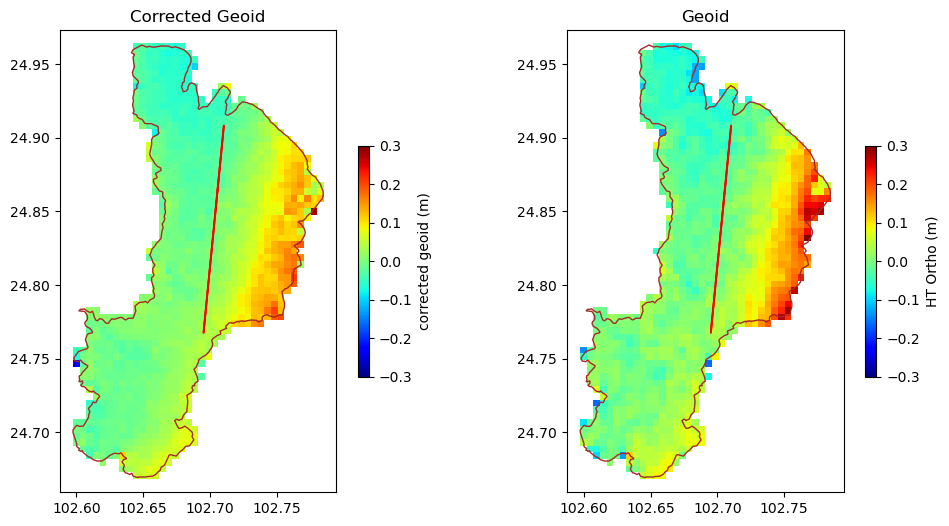

In [5]:
extent_raster = [raster_ht_spahet.x.min(), raster_ht_spahet.x.max(),
           raster_ht_spahet.y.min(), raster_ht_spahet.y.max()]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# geoid_mean = np.nanmean(raster_ht_spahet.geoid_cor_smoothed.values)
img_show1 = ax[0].imshow(raster_ht_spahet.ht_spahet_smoothed.values, cmap='jet', 
                        vmin = -0.3, vmax = 0.3, extent=extent_raster)
lake_gdf.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)
scat1 = ax[0].scatter(x=atl13_xr_mask.segment_lon, y=atl13_xr_mask.segment_lat, 
                      c='red', s=2, edgecolor='none')
plt.colorbar(img_show1, ax=ax[0], label='corrected geoid (m)', shrink=0.5)
ax[0].set_title('Corrected Geoid')
# geoid_mean = np.nanmean(raster_ht_spahet.geoid.values)
img_show2 = ax[1].imshow(raster_ht_spahet.geoid_spahet.values, cmap='jet', 
                         vmin = -0.3, vmax = +0.3,
                         extent=extent_raster)
lake_gdf.plot(ax=ax[1], edgecolor='Brown', facecolor='none', linewidth=1)
scat2 = ax[1].scatter(x=atl13_xr_mask.segment_lon, y=atl13_xr_mask.segment_lat,                       
                      c='red', s=2, edgecolor='none')
plt.colorbar(img_show2, ax=ax[1], label='HT Ortho (m)', shrink=0.5)
ax[1].set_title('Geoid')



### apply the corrected geoid 

In [6]:
## Sample corrected geoid values at ATL13 points
atl13_ht_spahet = sample_from_raster(
        raster_value=raster_ht_spahet.ht_spahet_smoothed.values,
        raster_x = raster_ht_spahet.x.values,
        raster_y = raster_ht_spahet.y.values,
        points_x = atl13_xr_mask.segment_lon.values,
        points_y = atl13_xr_mask.segment_lat.values
        )
atl13_ht_ortho = atl13_xr_mask.ht_water_surf.values - atl13_xr_mask.segment_geoid.values  ## equal to atl13_xr.ht_ortho
atl13_geoid_cor = atl13_xr_mask.segment_geoid.mean().values + atl13_ht_spahet
atl13_ht_ortho_cor = atl13_xr_mask.ht_water_surf.values - atl13_geoid_cor


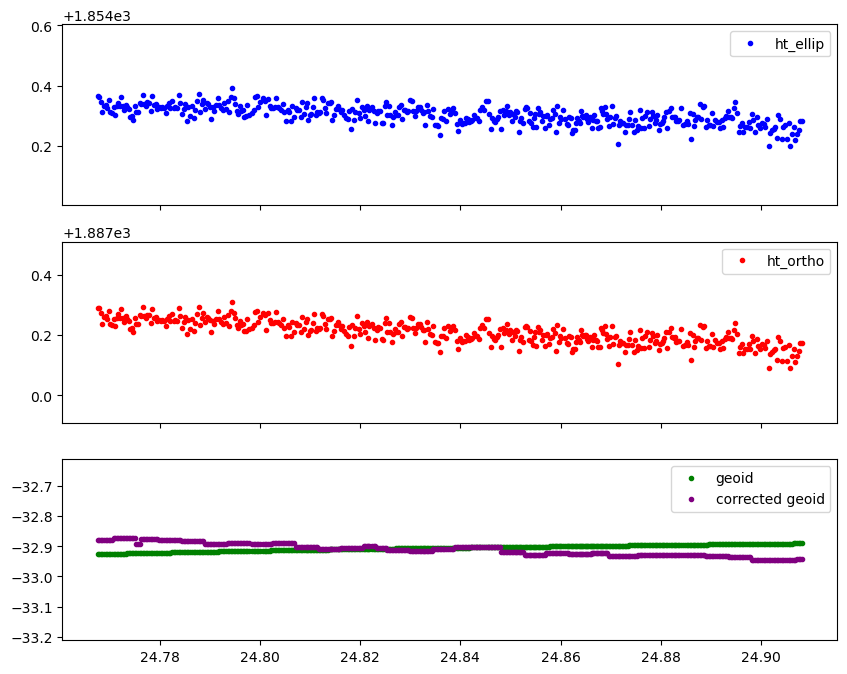

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
## plot height_ellip
ht_mean = np.mean(atl13_xr_mask.ht_water_surf.values)
ax[0].plot(atl13_xr_mask['segment_lat'], atl13_xr_mask.ht_water_surf.values, 
         marker='o', markersize=3, linestyle='None', 
         color='blue', label='ht_ellip')
ax[0].set_ylim(ht_mean - 0.3, ht_mean + 0.3)
ax[0].legend()
## plot height_ortho
ht_ortho_mean = np.nanmean(atl13_ht_ortho)
ax[1].plot(atl13_xr_mask['segment_lat'], atl13_ht_ortho, 
         marker='o', markersize=3, linestyle='None', 
         color='red', label='ht_ortho')
ax[1].set_ylim(ht_ortho_mean - 0.3, ht_ortho_mean + 0.3)
ax[1].legend()
## plot geoid
atl13_geoid_mean = np.nanmean(atl13_xr_mask.segment_geoid.values)
ax[2].plot(atl13_xr_mask['segment_lat'], atl13_xr_mask.segment_geoid.values, 
         marker='o', markersize=3, linestyle='None', 
         color='green', label='geoid')
ax[2].set_ylim(atl13_geoid_mean - 0.3, atl13_geoid_mean + 0.3)

atl13_geoid_cor_mean = np.nanmean(atl13_geoid_cor)
ax[2].plot(atl13_xr_mask['segment_lat'], atl13_geoid_cor,
         marker='o', markersize=3, linestyle='None', 
         color='purple', label='corrected geoid')
ax[2].set_ylim(atl13_geoid_cor_mean - 0.3, atl13_geoid_cor_mean + 0.3)
ax[2].legend()


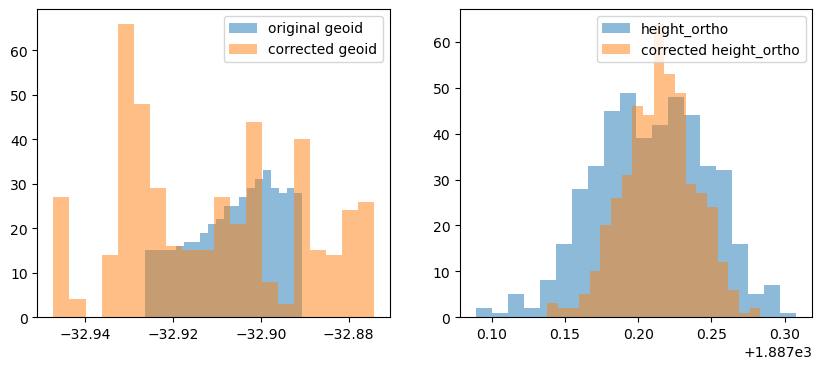

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(atl13_xr_mask.segment_geoid.values.ravel(), bins=20, alpha=0.5, label='original geoid');
ax[0].hist(atl13_geoid_cor.ravel(), bins=20, alpha=0.5, label='corrected geoid');
ax[0].legend();
ax[1].hist(atl13_ht_ortho, bins=20, alpha=0.5, label='height_ortho');
ax[1].hist(atl13_ht_ortho_cor, bins=20, alpha=0.5, label='corrected height_ortho');
ax[1].legend();


In [9]:
atl13_ht_ds = xr.Dataset({
  "geoid": (["delta_time"], atl13_xr_mask.segment_geoid.values),
  "geoid_cor": (["delta_time"], atl13_geoid_cor),  
  "ht_ortho": (["delta_time"], atl13_ht_ortho),
  "ht_ortho_cor": (["delta_time"], atl13_ht_ortho_cor)
}, coords={
  "delta_time": atl13_xr_mask["delta_time"],
  "segment_lon": atl13_xr_mask["segment_lon"],
  "segment_lat": atl13_xr_mask["segment_lat"]
})

path_save = path_atl13.replace('.h5', '_height.nc')
# atl13_ht_ds.to_netcdf(path_save)
atl13_ht_ds


<xarray.Dataset> Size: 22kB
Dimensions:       (delta_time: 456)
Coordinates:
  * delta_time    (delta_time) datetime64[ns] 4kB 2023-05-06T13:17:25.5484614...
    segment_lat   (delta_time) float64 4kB 24.91 24.91 24.91 ... 24.77 24.77
    segment_lon   (delta_time) float64 4kB 102.7 102.7 102.7 ... 102.7 102.7
Data variables:
    geoid         (delta_time) float32 2kB -32.89 -32.89 ... -32.93 -32.93
    geoid_cor     (delta_time) float64 4kB -32.94 -32.94 ... -32.88 -32.88
    ht_ortho      (delta_time) float32 2kB 1.887e+03 1.887e+03 ... 1.887e+03
    ht_ortho_cor  (delta_time) float64 4kB 1.887e+03 1.887e+03 ... 1.887e+03

In [10]:
print('std of geoid height:          ', np.nanstd(atl13_ht_ds['ht_ortho']))
print('std of geoid height corrected:', np.nanstd(atl13_ht_ds['ht_ortho_cor']))


std of geoid height:           0.038146306
std of geoid height corrected: 0.024275562283082575


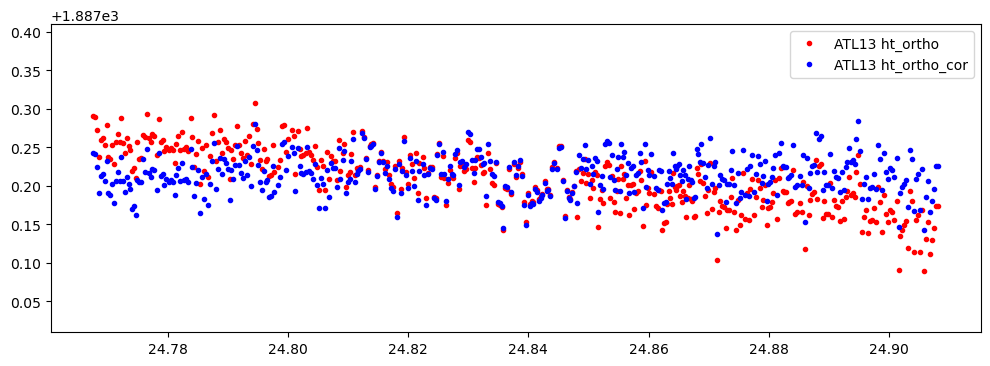

In [11]:
height_geoid_median = np.nanmedian(atl13_ht_ds['ht_ortho'])
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(atl13_xr_mask.segment_lat, atl13_ht_ds['ht_ortho'], 
                  marker='o', markersize=3, linestyle='None', 
                  color='red', label='ATL13 ht_ortho')

ax.plot(atl13_xr_mask.segment_lat, atl13_ht_ds['ht_ortho_cor'], 
                  marker='o', markersize=3, linestyle='None', 
                  color='blue', label='ATL13 ht_ortho_cor')
ax.set_ylim(height_geoid_median-0.2, height_geoid_median+0.2)
ax.legend()
